# Binary Classification on Tabular Data - Predicting Abnormal ECG Scans



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/snowport/snowport.github.io/blob/main/docs/notebooks/mitxpro/02_binary_classification.ipynb)

## Introduction

In this notebook, you will train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

## Technical preliminaries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
tf.random.set_seed(42)

pd.options.mode.chained_assignment = None

## Read in the data

Conveniently, the dataset in CSV form has been made available online and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [2]:
# Because each column of data represents a datapoint we will name the columns by the sequence of datapoints
# (1,2,3...140)
names = []
for i in range(140):
    names.append(i)
# The last column will be the target or dependent variable
names.append("Target")

Read in the data from http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv and set the column names from the list created in the box above

In [3]:
df = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)

df.columns = names

In [4]:
df.shape

(4998, 141)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,Target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Preprocessing

This dataset only has numeric variables. For consistency sake, we will assign the column names to variable numerics.


In [6]:
numerics = names

# Remove the dependent variable
numerics.remove("Target")

In [7]:
# Set the output to "target_metrics"
target_metrics = df.Target.value_counts(normalize=True)
print(target_metrics)

Target
1.0    0.584034
0.0    0.415966
Name: proportion, dtype: float64


Extract the dependent variable

In [8]:
# set the dependent variables to 'y'
y = df.pop("Target")


Before we normalize the numerics, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# split into train and test sets with the following naming conventions:
# X_train, X_test, y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [11]:
# Assign the means to "means" and standard deviation to "sd"
means = X_train[numerics].mean()
sd = X_train[numerics].std()
print(means)

0     -0.261910
1     -1.649880
2     -2.495738
3     -3.123526
4     -3.170804
         ...   
135   -0.779775
136   -0.842486
137   -0.640901
138   -0.484135
139   -0.704742
Length: 140, dtype: float64


Let's normalize the train and test dataframes with these means and standard deviations.

In [12]:
# Normalize X_train
X_train[numerics] = (X_train[numerics] - means) / sd

In [13]:
# Normalize X_test
X_test[numerics] = (X_test[numerics] - means) / sd

In [14]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
4321,0.942906,0.918411,0.756059,0.549809,0.279007,-0.000239,-0.318129,-0.297419,0.114735,0.023530,...,-0.844024,-1.079494,-1.169549,-1.291348,-1.581476,-1.596743,-1.503656,-1.144827,-0.926862,-0.418502
1589,-0.676037,-0.803506,-1.016787,-1.077450,-0.916263,-0.351198,0.628702,0.524610,0.673169,1.089889,...,0.858042,0.814006,0.978348,0.878989,0.727128,0.663161,0.757176,0.790068,0.355183,-0.646023
4109,1.272265,0.974431,0.564563,0.484635,0.155354,-0.257428,-0.765206,-0.598672,0.175432,-0.133798,...,0.182676,0.012165,-0.367248,-0.649725,-0.888969,-1.240149,-1.619437,-1.854891,-1.307798,-0.740308
1018,1.039653,0.543801,-0.172987,-0.433091,-1.105617,-1.650335,-1.218847,-0.441137,-0.787254,-0.423532,...,-0.347807,0.082412,0.571933,0.705932,0.906023,1.013345,0.982132,0.775867,0.316683,0.817843
3552,0.888205,1.145303,1.259494,1.365041,1.064103,0.257039,-0.683586,-1.330719,-1.119904,-0.882630,...,-0.741992,-1.023779,-1.223630,-1.312176,-1.534803,-1.621368,-1.564656,-1.259108,-0.915075,-0.044013


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [15]:
# Convert X_train and X_test to Numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [16]:
X_train.shape, y_train.shape

((3998, 140), (3998,))

In [17]:
X_test.shape, y_test.shape

((1000, 140), (1000,))

## Build a model

### Define model in Keras

Creating an NN  is usually just a few lines of Keras code.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

In [18]:
# get the number of columns and assign it to "num_columns"

num_columns = X_train.shape[1]

# Define the input layer. assign it to "input"
input = keras.Input(shape=(num_columns,), dtype="float32")

# Feed the input vector to the hidden layer. Call it "h"
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# Feed the output of the hidden layer to the output layer. Call it "output"
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model. Call it "model"
model = keras.Model(input, output)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273 (8.88 KB)

 Trainable params: 2,273 (8.88 KB)

 Non-trainable params: 0 (0.00 B)

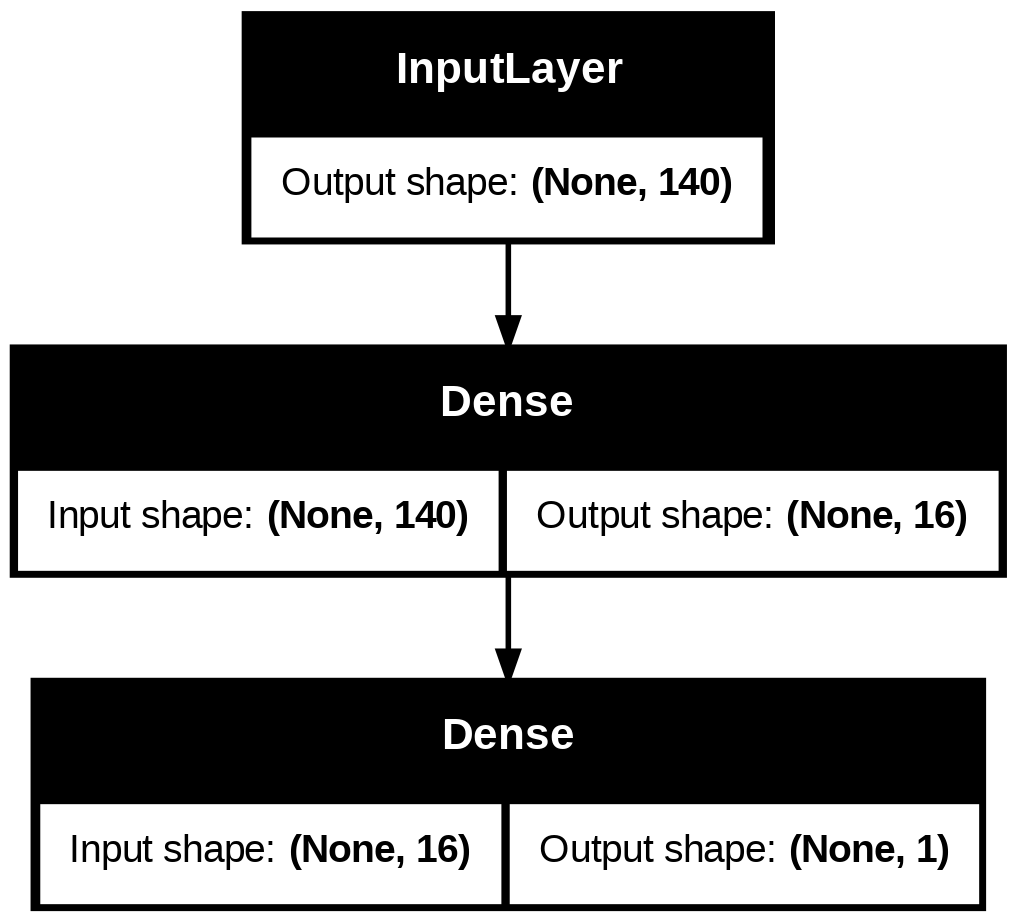

In [20]:
keras.utils.plot_model(model, show_shapes=True)

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a 'flavor' of SGD called `adam` which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, `accuracy` is commonly used.

In [21]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* (i.e., how many passes through the training data). Start by setting this to 100, but you can experiment with different values.
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

In [22]:
# Fit your model and assign the output to "history"
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2
)

Epoch 1/100
100/100 - 2s - 20ms/step - accuracy: 0.9506 - loss: 0.1612 - val_accuracy: 0.9812 - val_loss: 0.0573
Epoch 2/100
100/100 - 0s - 3ms/step - accuracy: 0.9856 - loss: 0.0520 - val_accuracy: 0.9862 - val_loss: 0.0411
Epoch 3/100
100/100 - 0s - 3ms/step - accuracy: 0.9906 - loss: 0.0397 - val_accuracy: 0.9875 - val_loss: 0.0347
Epoch 4/100
100/100 - 0s - 3ms/step - accuracy: 0.9916 - loss: 0.0334 - val_accuracy: 0.9875 - val_loss: 0.0312
Epoch 5/100
100/100 - 0s - 3ms/step - accuracy: 0.9919 - loss: 0.0289 - val_accuracy: 0.9887 - val_loss: 0.0287
Epoch 6/100
100/100 - 0s - 3ms/step - accuracy: 0.9931 - loss: 0.0257 - val_accuracy: 0.9900 - val_loss: 0.0272
Epoch 7/100
100/100 - 0s - 3ms/step - accuracy: 0.9941 - loss: 0.0232 - val_accuracy: 0.9900 - val_loss: 0.0264
Epoch 8/100
100/100 - 0s - 3ms/step - accuracy: 0.9941 - loss: 0.0210 - val_accuracy: 0.9900 - val_loss: 0.0251
Epoch 9/100
100/100 - 1s - 6ms/step - accuracy: 0.9953 - loss: 0.0192 - val_accuracy: 0.9912 - val_loss

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

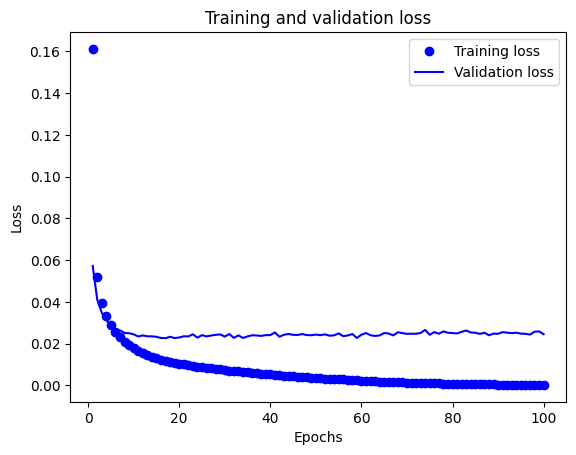

In [24]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

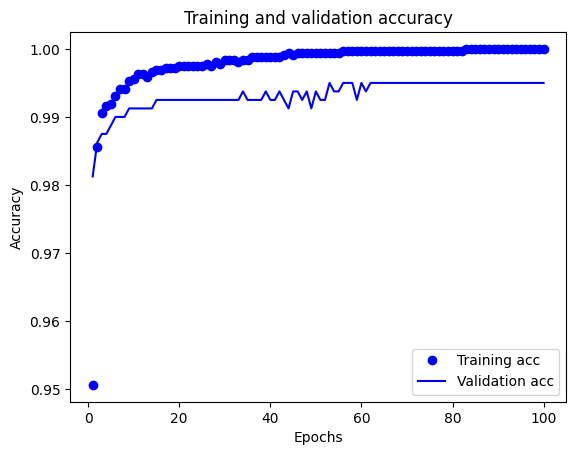

In [25]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate the model

Let's see **how well the model does on the test set**.

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [26]:
# Getting the results of your model for grading
score, acc = model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0876  


In [27]:
y.value_counts(normalize=True)

,proportion
Target,
1.0,0.584034
0.0,0.415966


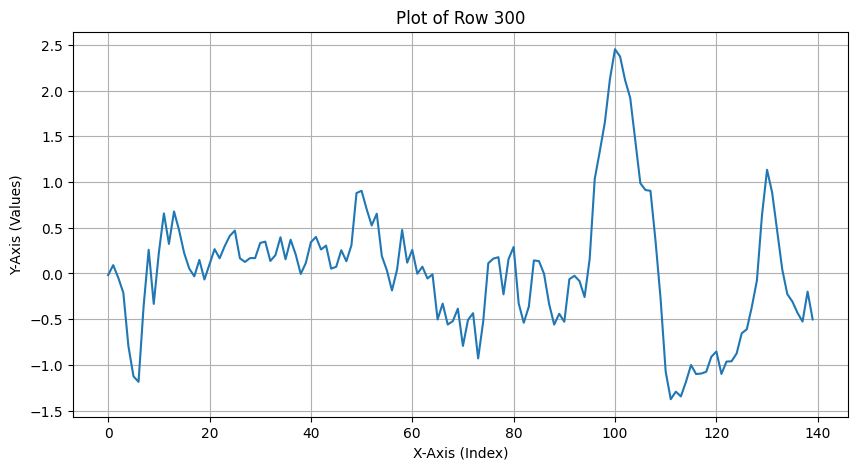

In [30]:
# Selecting a specific row (e.g., row index 300)
row_index = 300
y_values = X_train[row_index, :]
x_values = range(X_train.shape[1])  # X-axis: 0 to 139

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, linestyle="-")
plt.xlabel("X-Axis (Index)")
plt.ylabel("Y-Axis (Values)")
plt.title(f"Plot of Row {row_index}")
plt.grid(True)
plt.show()

In [31]:
print(y_train[row_index])  # Result is abnormal scan for row_index=300

0.0
